# PyTorch training loop and Testing loop

For the training loop, we'll build the following steps:

1. Forward pass
2. Calculate the loss
3. 	Zero gradients
4. Perform backpropagation on the loss
5. Update the optimizer (gradient descent)

In [7]:
import torch
import numpy as np
import seaborn as sns
from torch import nn

torch.manual_seed(42)

X = np.linspace(0,20,num=200)
y = X + np.sin(X)*2 + np.random.normal(size=X.shape)

<Axes: >

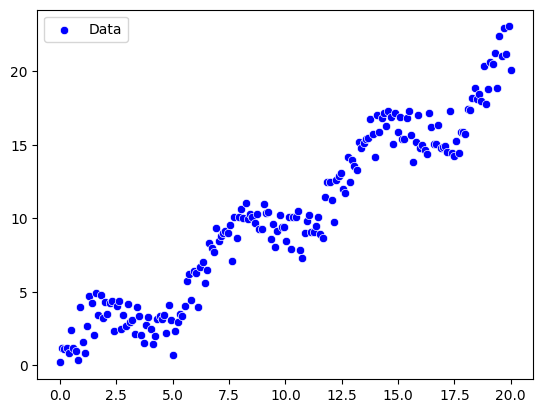

In [8]:
sns.scatterplot(x=X,y=y,color='Blue', label='Data')

In [9]:
from torch.utils.data import Dataset , DataLoader

class Simple1DRegressionDataset(Dataset):
    def __init__(self,X,y):
        super(Simple1DRegressionDataset,self).__init__()
        self.X = X.reshape(-1,1)
        self.y = y.reshape(-1,1)

    def __getitem__(self,index):
        return torch.tensor(self.X[index,:],dtype=torch.float32) , torch.tensor(self.y[index,:],dtype=torch.float32)

    def __len__(self):
        return self.X.shape[0]

In [10]:
df = Simple1DRegressionDataset(X,y)


In [11]:
df[0]


(tensor([0.]), tensor([0.1984]))

In [12]:
training_loader = DataLoader(Simple1DRegressionDataset(X,y),batch_size=2,shuffle=True)

In [13]:
data_point = next(iter(training_loader))
data_point


[tensor([[ 8.8442],
         [10.8543]]),
 tensor([[9.2953],
         [8.9891]])]

In [14]:
# construct the model using Linear block
in_features = 1
out_features = 1
class FCN(nn.Module):
    def __init__(self,in_features,hidden=128, out_features=1):
        super(FCN,self).__init__()
        self.input = nn.Linear(in_features,hidden)
        self.tanh = nn.Tanh()
        self.hidden = nn.Linear(hidden,hidden)
        self.output = nn.Linear(hidden,out_features)

    def forward(self,x):
        x = self.input(x)
        x = self.tanh(x)
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.hidden(x)
        x = self.tanh(x)
        x = self.output(x)

        return x
model_2 = FCN(in_features=in_features,hidden=128,out_features=out_features)


In [15]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),lr=0.001)

In [16]:
# so we need now a training loop
from tqdm.autonotebook import tqdm

def train_simple_network(model,
                        loss_fn,
                        training_loader,
                        epochs=50,
                        device='cpu', optimizer=optimizer):

    model.to(device)
    pbar = tqdm(range(epochs), desc="Epochs")

    for epoch in pbar:

        model = model.train()

        running_loss = 0

        for inputs , labels in tqdm(training_loader,desc='Batches'):

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            y_pred = model(inputs)

            loss = loss_fn(y_pred, labels)

            loss.backward()

            optimizer.step()

            running_loss += loss.item()

        pbar.set_description(f"Loss: {running_loss/len(training_loader):.4f}", refresh=True)



In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
train_simple_network(model_2,
                loss_fn,
                training_loader,
                device=device,
                epochs=2000
                )


Epochs:   0%|          | 0/2000 [00:00<?, ?it/s]

Loss: 1.4313: 100%|██████████| 2000/2000 [09:54<00:00,  3.36it/s]


In [19]:
# lets try our model
model_2.to('cpu')

model_2.eval()

with torch.inference_mode():
    y_pred_m2 = model_2(torch.tensor(X,dtype=torch.float32).reshape(-1,1)).cpu().numpy()

<Axes: >

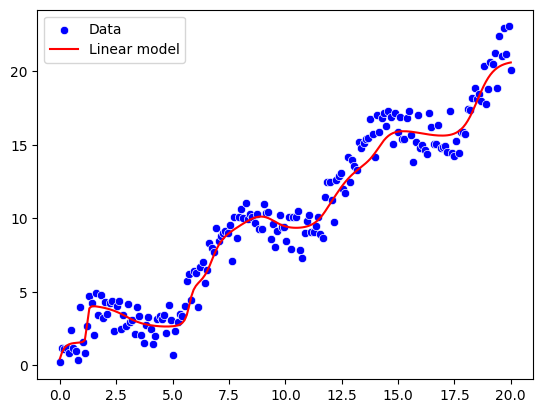

In [20]:
sns.scatterplot(x=X,y=y , color='blue',label='Data')
sns.lineplot(x=X,y=y_pred_m2.ravel(),color='red',label='Linear model')
